In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.6 MB/s eta 0:00:00


In [ ]:
!pip install -q torch-scatter torch-sparse torch-cluster torch-spline-conv \
  -f https://data.pyg.org/whl/torch-2.4.0+cu121.html


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 86.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 79.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.8/989.8 kB 44.3 MB/s eta 0:00:00


In [ ]:
import os
import torch
from torch import nn
from torch.optim import AdamW
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import QM9
from torch_geometric.nn.models import SchNet

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TARGET = 0  # QM9 has 19 targets; 0 = dipole moment (mu)

def split(dataset, r_train=0.8, r_val=0.1, seed=42):
    torch.manual_seed(seed)
    n = len(dataset)
    idx = torch.randperm(n)
    n_tr = int(n * r_train)
    n_va = int(n * (r_train + r_val))
    return dataset[idx[:n_tr]], dataset[idx[n_tr:n_va]], dataset[idx[n_va:]]

def main():
    print(f"Device: {DEVICE}")
    path = os.path.join("data", "QM9")
    ds = QM9(path)

    # Standardize target (in-place; fine for a quick POC)
    y = ds.data.y[:, TARGET]
    y_mean, y_std = y.mean(), y.std()
    ds.data.y[:, TARGET] = (y - y_mean) / (y_std + 1e-8)

    train_ds, val_ds, test_ds = split(ds)
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=128, shuffle=False)
    test_loader  = DataLoader(test_ds, batch_size=128, shuffle=False)

    # Version-agnostic SchNet: do not pass out_channels/num_outputs
    model = SchNet(
        hidden_channels=128,
        num_filters=128,
        num_interactions=3,
        num_gaussians=50,
        cutoff=10.0,
        max_num_neighbors=32
    ).to(DEVICE)

    opt = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)
    loss_fn = nn.MSELoss()

    def run(loader, train: bool = False):
        model.train() if train else model.eval()
        tot_loss, n_graphs = 0.0, 0
        with torch.set_grad_enabled(train):
            for batch in loader:
                batch = batch.to(DEVICE)
                # IMPORTANT: pass batch.batch for graph-level pooling inside SchNet
                pred = model(batch.z, batch.pos, batch.batch)
                # Ensure shape [B, 1]
                if pred.dim() == 1:
                    pred = pred.unsqueeze(1)
                y_t = batch.y[:, TARGET:TARGET+1]
                loss = loss_fn(pred, y_t)
                if train:
                    opt.zero_grad()
                    loss.backward()
                    opt.step()
                tot_loss += loss.item() * batch.num_graphs
                n_graphs += batch.num_graphs
        # RMSE on standardized target
        return (tot_loss / max(n_graphs, 1)) ** 0.5

    best_val = float("inf")
    for epoch in range(1, 51):
        train_rmse = run(train_loader, train=True)
        val_rmse = run(val_loader, train=False)
        if val_rmse < best_val:
            best_val = val_rmse
            torch.save(model.state_dict(), "schnet_qm9.pt")
        print(f"Epoch {epoch:03d} | train RMSE {train_rmse:.4f} | val RMSE {val_rmse:.4f}")

    # Test with best checkpoint
    model.load_state_dict(torch.load("schnet_qm9.pt", map_location=DEVICE))
    test_rmse = run(test_loader, train=False)
    print(f"Test RMSE (standardized): {test_rmse:.4f}")

if __name__ == "__main__":
    main()


/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_scatter_cuda.so: undefined symbol: _ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_St8optionalIN3c1017basic_string_viewIcEEE
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_spline_conv/_basis_cuda.so: undefined symbol: _ZN5torch8autograd12VariableInfoC1ERKN2at6TensorE
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_spmm_cuda.so: undefined sy

Device: cuda


Extracting data/QM9/raw/qm9_v3.zip
Processing...
Using a pre-processed version of the dataset. Please install 'rdkit' to alternatively process the raw data.
Done!
/usr/local/lib/python3.11/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 001 | train RMSE 1.1619 | val RMSE 0.6717
Epoch 002 | train RMSE 0.6456 | val RMSE 0.6381
Epoch 003 | train RMSE 0.5418 | val RMSE 0.6517
Epoch 004 | train RMSE 0.4654 | val RMSE 0.3931
Epoch 005 | train RMSE 0.4102 | val RMSE 0.3694
Epoch 006 | train RMSE 0.3827 | val RMSE 0.3416
Epoch 007 | train RMSE 0.3398 | val RMSE 0.3314
Epoch 008 | train RMSE 0.3090 | val RMSE 0.3033
Epoch 009 | train RMSE 0.2850 | val RMSE 0.3238
Epoch 010 | train RMSE 0.2630 | val RMSE 0.2730
Epoch 011 | train RMSE 0.2507 | val RMSE 0.2594
Epoch 012 | train RMSE 0.2274 | val RMSE 0.2364
Epoch 013 | train RMSE 0.2188 | val RMSE 0.2002
Epoch 014 | train RMSE 0.2015 | val RMSE 0.2133
Epoch 015 | train RMSE 0.1943 | val RMSE 0.1889
Epoch 016 | train RMSE 0.1880 | val RMSE 0.2278
Epoch 017 | train RMSE 0.1846 | val RMSE 0.1705
Epoch 018 | train RMSE 0.1833 | val RMSE 0.1746
Epoch 019 | train RMSE 0.1664 | val RMSE 0.1708
Epoch 020 | train RMSE 0.1661 | val RMSE 0.2195
Epoch 021 | train RMSE 0.1656 | val RMSE

Test RMSE (original units): 0.1550 | MAE: 0.1086


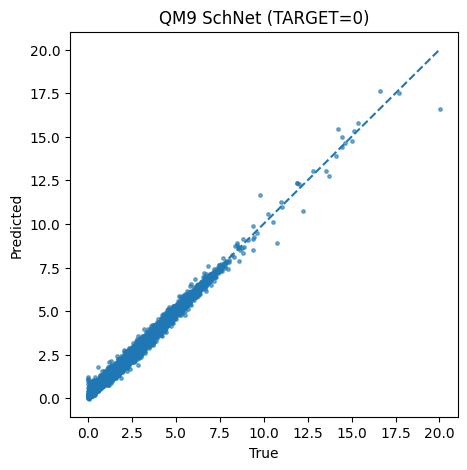

In [ ]:
# --- eval + plot for the trained model ---
import os, math, torch, matplotlib.pyplot as plt
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn.models import SchNet

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TARGET = 0  # dipole moment (mu) in Debye for QM9

def split(dataset, r_train=0.8, r_val=0.1, seed=42):
    torch.manual_seed(seed); n=len(dataset); idx=torch.randperm(n)
    n_tr=int(n*r_train); n_va=int(n*(r_train+r_val))
    return dataset[idx[:n_tr]], dataset[idx[n_tr:n_va]], dataset[idx[n_va:]]

# reload dataset & stats (same as training)
ds = QM9(os.path.join("data","QM9"))
y = ds.data.y[:, TARGET]
y_mean, y_std = y.mean(), y.std()
ds.data.y[:, TARGET] = (y - y_mean) / (y_std + 1e-8)
_, _, test_ds = split(ds)

test_loader = DataLoader(test_ds, batch_size=256, shuffle=False)

model = SchNet(hidden_channels=128, num_filters=128, num_interactions=3,
               num_gaussians=50, cutoff=10.0, max_num_neighbors=32).to(DEVICE)
model.load_state_dict(torch.load("schnet_qm9.pt", map_location=DEVICE))
model.eval()

preds_std, trues_std = [], []
with torch.no_grad():
    for b in test_loader:
        b = b.to(DEVICE)
        p = model(b.z, b.pos, b.batch)
        if p.dim()==1: p = p.unsqueeze(1)
        preds_std.append(p.cpu())
        trues_std.append(b.y[:, TARGET:TARGET+1].cpu())

import torch as T
preds_std = T.cat(preds_std).squeeze(1)
trues_std = T.cat(trues_std).squeeze(1)

# un-standardize to physical units
preds = preds_std * y_std + y_mean
trues = trues_std * y_std + y_mean

rmse = math.sqrt(((preds - trues)**2).mean().item())
mae  = (preds - trues).abs().mean().item()
print(f"Test RMSE (original units): {rmse:.4f} | MAE: {mae:.4f}")

# scatter plot
plt.figure(figsize=(5,5))
plt.scatter(trues.numpy(), preds.numpy(), s=6, alpha=0.6)
m = max(trues.max().item(), preds.max().item())
plt.plot([0,m],[0,m], linestyle="--")
plt.xlabel("True"); plt.ylabel("Predicted"); plt.title("QM9 SchNet (TARGET=0)")
plt.show()


Extracting data/QM9/raw/qm9.zip


RMSE 0.1550 Debye | MAE 0.1086 | R^2 0.989


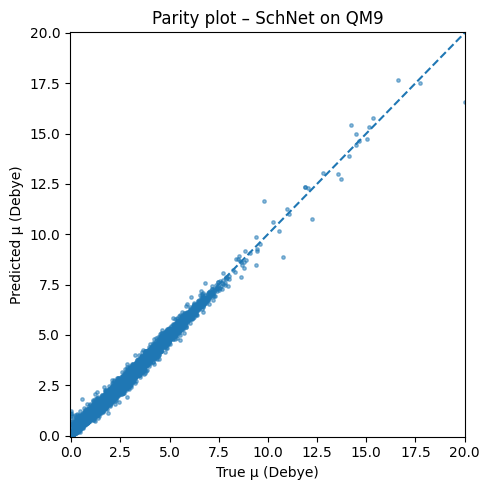

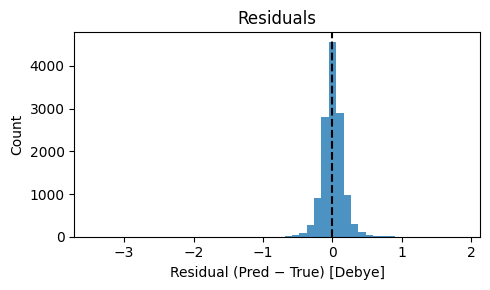

In [ ]:
# assumes you already evaluated test loader and have ds, y_mean, y_std, and a trained `model`
import math, torch, matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import QM9
from torch_geometric.nn.models import SchNet
import numpy as np, os

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TARGET = 0

def split(dataset, r_train=0.8, r_val=0.1, seed=42):
    torch.manual_seed(seed); n=len(dataset); idx=torch.randperm(n)
    n_tr=int(n*r_train); n_va=int(n*(r_train+r_val))
    return dataset[idx[:n_tr]], dataset[idx[n_tr:n_va]], dataset[idx[n_va:]]

# reload data & stats as in training
ds = QM9(os.path.join("data","QM9"))
y = ds.data.y[:, TARGET]
y_mean, y_std = y.mean(), y.std()
ds.data.y[:, TARGET] = (y - y_mean) / (y_std + 1e-8)
_, _, test_ds = split(ds)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False)

# same SchNet config as training
model = SchNet(hidden_channels=128, num_filters=128, num_interactions=3,
               num_gaussians=50, cutoff=10.0, max_num_neighbors=32).to(DEVICE)
model.load_state_dict(torch.load("schnet_qm9.pt", map_location=DEVICE))
model.eval()

preds_std, trues_std = [], []
with torch.no_grad():
    for b in test_loader:
        b = b.to(DEVICE)
        p = model(b.z, b.pos, b.batch)
        if p.dim()==1: p = p.unsqueeze(1)
        preds_std.append(p.cpu())
        trues_std.append(b.y[:, TARGET:TARGET+1].cpu())

preds_std = torch.cat(preds_std).squeeze(1)
trues_std = torch.cat(trues_std).squeeze(1)
preds = preds_std * y_std + y_mean
trues = trues_std * y_std + y_mean
resid = (preds - trues).numpy()

# Metrics
rmse = math.sqrt(((preds - trues)**2).mean().item())
mae  = (preds - trues).abs().mean().item()
r2   = 1 - ((preds - trues).pow(2).sum() / (trues - trues.mean()).pow(2).sum()).item()
print(f"RMSE {rmse:.4f} Debye | MAE {mae:.4f} | R^2 {r2:.3f}")

# Parity plot
plt.figure(figsize=(5,5))
plt.scatter(trues, preds, s=6, alpha=0.5)
lims = [float(min(trues.min(), preds.min())), float(max(trues.max(), preds.max()))]
plt.plot(lims, lims, '--')
plt.xlim(lims); plt.ylim(lims)
plt.xlabel("True μ (Debye)"); plt.ylabel("Predicted μ (Debye)")
plt.title("Parity plot – SchNet on QM9")
plt.tight_layout(); plt.show()

# Residuals histogram
plt.figure(figsize=(5,3))
plt.hist(resid, bins=50, alpha=0.8)
plt.axvline(0, color='k', linestyle='--')
plt.xlabel("Residual (Pred − True) [Debye]"); plt.ylabel("Count")
plt.title("Residuals")
plt.tight_layout(); plt.show()


Pred μ (Debye): 1.411


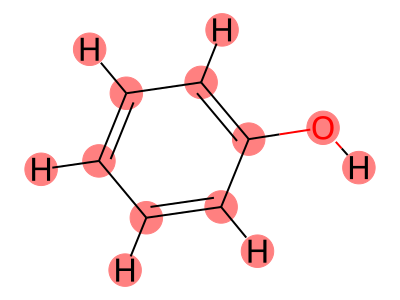

In [ ]:
!pip -q install rdkit-pypi

from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from torch_geometric.data import Data

def smiles_to_graph(smiles):
    m = Chem.MolFromSmiles(smiles)
    m = Chem.AddHs(m)
    AllChem.EmbedMolecule(m, AllChem.ETKDG())
    AllChem.UFFOptimizeMolecule(m)
    z, pos = [], []
    conf = m.GetConformer()
    for a in m.GetAtoms():
        z.append(a.GetAtomicNum())
        p = conf.GetAtomPosition(a.GetIdx())
        pos.append([p.x, p.y, p.z])
    z = torch.tensor(z, dtype=torch.long)
    pos = torch.tensor(pos, dtype=torch.float)
    batch = torch.zeros(len(z), dtype=torch.long)
    return m, z, pos, batch

def predict_raw(z, pos, batch):
    with torch.no_grad():
        p = model(z.to(DEVICE), pos.to(DEVICE), batch.to(DEVICE))
        if p.dim()==0: p = p.view(1)
        return p.cpu().item()

def occlusion_importance(smiles):
    m, z, pos, batch = smiles_to_graph(smiles)
    full_std = predict_raw(z, pos, batch)            # standardized
    full = full_std * y_std.item() + y_mean.item()   # Debye
    imp = []
    for i in range(len(z)):
        z2 = torch.cat([z[:i], z[i+1:]])
        pos2 = torch.cat([pos[:i], pos[i+1:]], dim=0)
        batch2 = torch.zeros(len(z2), dtype=torch.long)
        std_i = predict_raw(z2, pos2, batch2)
        pred_i = std_i * y_std.item() + y_mean.item()
        imp.append(abs(full - pred_i))
    return m, imp, full

m, imp, full_pred = occlusion_importance("c1ccccc1O")  # phenol
print("Pred μ (Debye):", round(full_pred, 3))

# Normalize importance to [0,1]
mx = max(imp) if max(imp)>0 else 1.0
imp_norm = [x/mx for x in imp]

# RDKit atom heatmap
atom_colors = {i: (1.0, 0.0, 0.0, imp_norm[i]) for i in range(m.GetNumAtoms())}  # red with alpha
img = Draw.MolToImage(m, size=(400,300), highlightAtoms=list(range(m.GetNumAtoms())),
                      highlightAtomColors=atom_colors)
display(img)


In [ ]:
!pip -q install py3Dmol
import py3Dmol
from rdkit.Chem import AllChem

mb = Chem.MolToMolBlock(m)  # reuse `m` from above
view = py3Dmol.view(width=500, height=400)
view.addModel(mb, 'sdf')
# color by importance (blue low → red high)
for i,val in enumerate(imp_norm):
    color = f"0x{int(255*val):02x}0000"  # red scale
    view.setStyle({'serial': i+1}, {"sphere": {"scale": 0.35, "color": color}})
view.zoomTo(); view.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.